In [1]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
import csv
import functools

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter

import copy

# bibliografie: 
# https://blog.sicara.com/getting-started-genetic-algorithms-python-tutorial-81ffa1dd72f9
# https://www.tutorialspoint.com/genetic_algorithms/index.htm
# https://www.analyticsvidhya.com/blog/2017/07/introduction-to-genetic-algorithm/

# Algoritmi genetici

Calculul maximului functiei $f: [-10, 10] \times [-20, 20] \rightarrow (0, \infty)$,

$$f(x, y) =
100 
\left(
    \left(
       -20 \exp\left( -0.2 \sqrt{0.5 (x^2+y^2)} \right)
       -
       \exp
       \left(
          0.5 \left( \cos(2 \pi x) + \cos(2 \pi y)\right)
       \right)
    \right) + e + 100
\right)
$$

In [2]:
left_interval_1, right_interval_1 = -10, 10
left_interval_2, right_interval_2 = -20, 20 

<IPython.core.display.Javascript object>


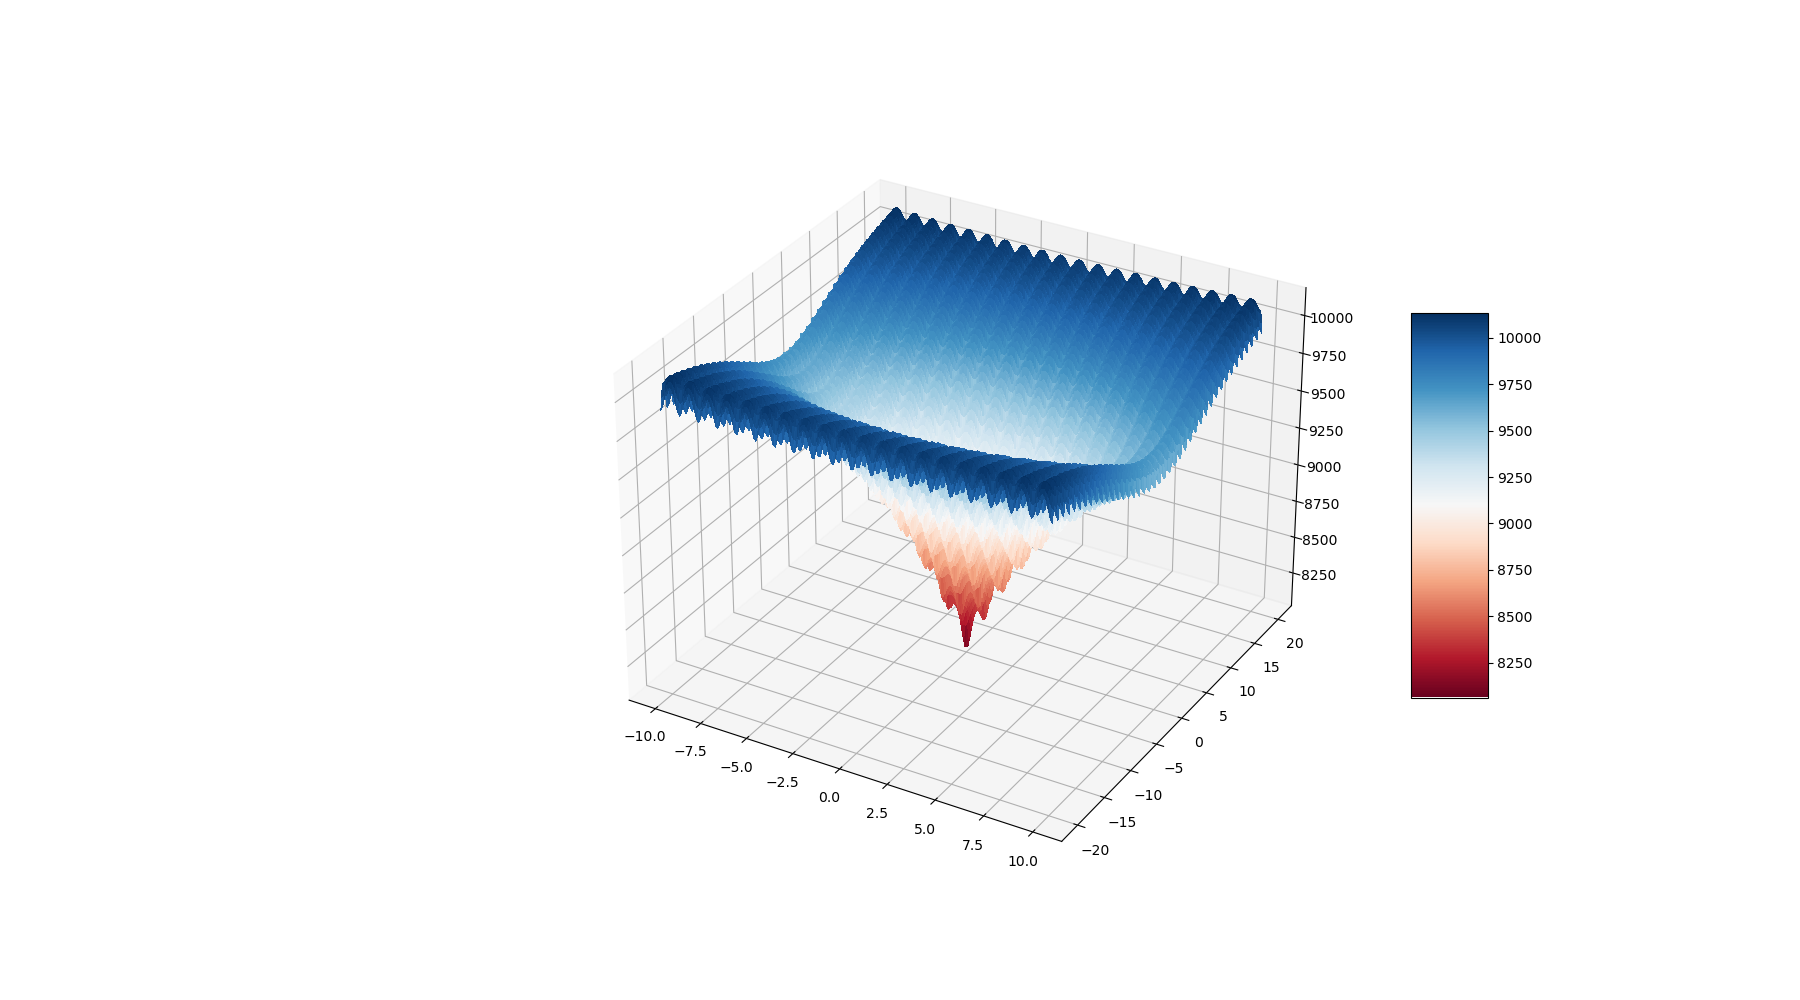

In [3]:
def f(x, y):
    return 100 * (-20.0 * np.exp(-0.2 * np.sqrt(0.5 * (x**2 + y**2))) - \
np.exp(0.5 * (np.cos(2 * np.pi * x) + np.cos(2 * np.pi * y))) + np.e + 100)


# 200 de puncte pe fiecare directie
sampling = 200

# plt.figure(figsize=(15, 8))

# cream o esantionare de puncte cu numar de puncte dat, pentru fiecare coordonata
x = np.linspace(left_interval_1, right_interval_1, num=sampling)
y = np.linspace(left_interval_2, right_interval_2, num=sampling)

# se creeaza o grila de puncte pe fiecare dimensiune
X, Y = np.meshgrid(x, y)
Z = np.zeros((sampling, sampling))

# se calculeaza valoarea functiei in fiecare punct in acea grila
for i in range(sampling):
    for j in range(sampling):
        Z[i, j] = f(X[i, j], Y[i, j])
        
# crearea unei figuri si setarea dimensiunilor sale
fig = plt.figure()
fig.set_size_inches(18, 10)

# reprezentare 3D
ax = fig.add_subplot(projection='3d')
surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, cmap=cm.RdBu, linewidth=0, antialiased=False)

# adaugarea legendei si reprezentarea
fig.colorbar(surf, shrink=0.5, aspect=5)
plt.show()

# Pasi de urmat

1. Se implementeaza functiile de mai jos. Asertiunile trebuie indeplinite
1. La final va rezulta un fisier txt cu structura similara cu cea a fisierului 'exemplu_fisier_iesire.txt' (ignorati continutul numeric, urmariti formatarea)
1. Fisierul de la punctul anterior se va plota in notebookul `plot_GA.ipynb`. Graficul ar trebui sa arate o alura crescatoare a medie populatiei

# Cod

In [4]:
# converteste o lista de k biti in valoare in baza 10

def binary_to_int(bits):
    """
    converteste o lista de k biti in valoare in baza 10
    
    :param bits: lista de biti
    """
    # res = "".join(map(str, bits))
    s=[str(i) for i in bits]
    # print(s)
    res = "".join(s)
    # print(res)
    result = int(res,2)
    # print(result)
    return result
    
assert binary_to_int([0, 0, 0]) == 0
assert binary_to_int([0, 1, 0]) == 2
assert binary_to_int([1, 0, 1]) == 5
assert binary_to_int([1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,1,0,0,1]) == 598601

In [5]:
def x_c(v, a, b, k):
    """
    Convert the bit value of v to a value within the interval [a, b]
    :param v: value of current chromozome in base 10
    :param a: left limit of interval
    :param b: right limit of interval
    :param k: number of bits 
    :return: a value within [a, b]
    """
    result = a + np.multiply(v, (b-a)/(np.power(2,k)-1))
    return result

assert(x_c(0, 3, 10, 10) == 3)
assert(x_c((1 << 10) - 1, 3, 10, 10) == 10)
assert(x_c(0, 4, 8, 10) == 4)
assert(x_c((1 << 10) - 1, 4, 8, 10) == 8)

In [6]:
def selection(population):
    """
    Functia de selectie primeste populatia de cromozomi, impreuna cu k, lungimea unui cromozom,
    si creeaza o noua generatie
    
    :param population: lista de tuple de cromozomi; primul cromozom codifica valoare din [3, 10], 
                        al doilea din [4, 8]
    :param k: numarul de gene din fiecare cromozom
    
    Un cromozom este o lista de biti.
    
    Va intoarce noua generatie de cromzomi: lista de tuple de 2 cromozomi
    
    Atentie: in populatia selectata, un individ valoros poate sa fie selectat de mai multe ori. 
    Pentru a evita ca mutatiile ulterioare sa afecteze in mod repeatat acelasi individ (aceeasi referinta)
    se va face un deepcopy (copy.deepcopy) al individului depus in populatia selectata
    """
    # population is a list
    assert isinstance(population, list) and len(population) > 1
    # each chromosome is a tuple of two components
    assert all(isinstance(item, tuple) and len(item) == 2 for item in population), 'Should be a list of 2-tuples'
    # each component of a chromosome is a list
    assert all(isinstance(item[0], list) and isinstance(item[1], list) for item in population), 'Any tuple member should be a list'
    # .. and each of these lists have the same length
    assert all(len(item[0]) == len(item[1]) for item in population)
    
    k = len(population[0][0]) #lungimea unui cromozon

    y = [f(x_c(binary_to_int(chromosome[0]), 3, 10, k), x_c(binary_to_int(chromosome[1]), 4, 8, k)) for chromosome in population]
    assert all(f_value > 0 for f_value in y)
    
    # calculeaza s, suma tuturor valorilor din y
    s = np.sum(y)
    
    # calculeaza probabilitatile de selectie
    p = [f_value/s for f_value in y]
    
    # calculeaza probabilitatea cumulativa de selectie; puteti folosi functia np.cumsum
    q = np.cumsum(p)
    
    selected_population = []
    # creaaza populatia selectata
    for _ in range(len(population)):
        r = np.random.random()
        for i in range(len(q)):
            if r < q[i]:
                selected_population.append(copy.deepcopy(population[i]))
                break

    # print(selected_population)
    return selected_population

test_population = [
    ([0, 0, 0, 0], [0, 0, 0, 0]),
    ([1, 0, 0, 1], [0, 1, 1, 0]),
    ([0, 1, 1, 0], [1, 0, 0, 0]),
    ([1, 0, 0, 0], [1, 1, 1, 1]),
] * 100
k = len(test_population[0][0])
selected_population = selection(test_population)

assert len(selected_population) == len(test_population)
assert isinstance(selected_population, list) and len(selected_population) > 1
assert all(isinstance(item, tuple) and len(item) == 2 for item in selected_population), 'Should be a list of 2-tuples'
assert all(isinstance(item[0], list) and isinstance(item[1], list) for item in selected_population), 'Any tuple member should be a list'
assert all(len(item[0]) == len(item[1]) == k for item in selected_population)

# the selected chrmosome are among the original chromosomes
assert all(str(item_selected[0]) in set(str(item_original[0]) for item_original in test_population) for item_selected in selected_population)
assert all(str(item_selected[1]) in set(str(item_original[1]) for item_original in test_population) for item_selected in selected_population)

# check if deepcopy was used: the individual id's should be distinct
assert len(selected_population) == len(set(id(individual) for individual in selected_population))

In [7]:
def crossover_chr(a, b, t):
    """
    Procedura de crossover va genera alti doi cromozomi in care primii t biti din a si b
    vor fi inversati intre cromozomi.
    
    :param a: lista de gene (biti)
    :param b: lista de gene (biti)
    :param t: taietura, 0 < t < k
    :return: un tuplu de 2 liste, continand genele copiilor rezultati
    """
    assert len(a) == len(b)
    k = len(a)
    assert 0 < t < k
    ...
    child1 = a.copy()
    child2 = b.copy()
    child1=a[:t] +b[t:]
    child2=b[:t] + a[t:]
    return child1, child2

a = [1,1,1,1,1,0,0,0,1,1]
b = [0,1,0,0,1,1,1,1,0,0]
a, b = crossover_chr(a, b, 4)
assert(a == [1,1,1,1,1,1,1,1,0,0])
assert(b == [0,1,0,0,1,0,0,0,1,1])

In [8]:
def crossover(population, pc = 0.1):
    """
    Selecteaza cativa cromozomi din populatie si face cross-over intre ei, pe perechi
    
    """
    n = len(population)
    k = len(population[0][0])
    ...
    print (n)
    print (k)
    # print(population)

    # parent1 =  
    # parent2 =
    # # cross_population
    
    return ...

crossover_population = crossover(test_population)
# same number of individuals as before
assert len(crossover_population) == len(test_population)
assert isinstance(crossover_population, list) and len(crossover_population) > 1
assert all(isinstance(item, tuple) and len(item) == 2 for item in crossover_population), 'Should be a list of 2-tuples'
assert all(isinstance(item[0], list) and isinstance(item[1], list) for item in crossover_population), 'Any tuple member should be a list'
assert all(len(item[0]) == len(item[1]) for item in crossover_population)

400
4


TypeError: object of type 'ellipsis' has no len()

In [ ]:
def mutate_chr(a, t):
    """
    Procedura de mutatie va reseta/seta un bit din cromozom
    a este cromozomul reprezentat ca lista de biti
    t este pozitia ce se schimba
    se returneaza un sir de k gene (biti)
    """
    k = len(a)
    assert 0 <= t < k
    ...
    
    return ...

assert(mutate_chr([1,1,1,1,0,0,0,0,1,1], 6) == [1,1,1,1,0,0,1,0,1,1])
assert(mutate_chr([1,1,1,1,0,0,0,0,1,1], 7) == [1,1,1,1,0,0,0,1,1,1])
assert(mutate_chr([1,1,1,1,0,0,0,0,1,1], 0) == [0,1,1,1,0,0,0,0,1,1])

In [ ]:
# mutation
def mutation(population, pm = 0.01):
    """
    Procedura de mutation va produce mutatii in populatie
    pm este probabilitatea mutatiei
    """
    ...
    
    return ...

mutated_population = crossover(test_population)
# same number of individuals as before
assert len(mutated_population) == len(test_population)
assert isinstance(mutated_population, list) and len(mutated_population) > 1
assert all(isinstance(item, tuple) and len(item) == 2 for item in mutated_population), 'Should be a list of 2-tuples'
assert all(isinstance(item[0], list) and isinstance(item[1], list) for item in mutated_population), 'Any tuple member should be a list'
assert all(len(item[0]) == len(item[1]) for item in mutated_population)

In [ ]:
def compute_average(population):
    """
    Calculeaza media valorii functiei obiectiv pentru populatia data
    """
    
    ...
    
    return ...

def maximum(population):
    """
    Calculeaza maximul valorii functiei obiectiv pentru populatia data
    """
    k = len(population[0][0])
    
    ...
    
    return ...

In [ ]:
def write_population(file, population):
    """
    Scrie populatia in fisierul text file deschis anterior (atentie la conversia \r\n, daca e cazul)
    """
    
    ...

In [ ]:
# crearea populatiei initiale, 20 de biti per cromozom
k = 20
n = 100

# creeaza populatia, random
population = [
    ...
]

# deschide fisierul de iesire
file = open("output.txt", "w")

# selection
generations = 50
for i in range(generations):
    # scrie antetul populatiei, "#numar generatie: .."
    ...
    
    # scrie populatia
    write_population(file, population)
    
    # scrie #sfarsit date generatie 
    ...
    
    # tipareste pe ecran media populatiei si maximul
    # pe parcursul generatiilor, media populatiei ar trebui sa fie monoton crescatoare
    ...
    
    # apeleaza, in ordine, selection, crossover si mutation
    ...
    
# scrie media si maximul ultimei iteratii
...

# inchide fisierul
file.close()